In [1]:
from RNNEnv import RNNClass
from tensorflow.keras.layers import SimpleRNN, LSTM
import numpy as np

In [2]:
ModelRNN = RNNClass(feature_steps=1,target_steps=1,tickers = ['spy'],layers_LSTM=1,layers_RNN=1,batchnormalization=True, epochs = 200, patience = 500,
                     learning_rate=0.00001,HuberDelta_p=0.0001,HuberDelta_n=0.0001)

for m in [SimpleRNN,LSTM]:
    ModelRNN.Prediction(m)

c:\Users\yoshi\anaconda3\envs\SimulatingScenarios\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\yoshi\anaconda3\envs\SimulatingScenarios\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


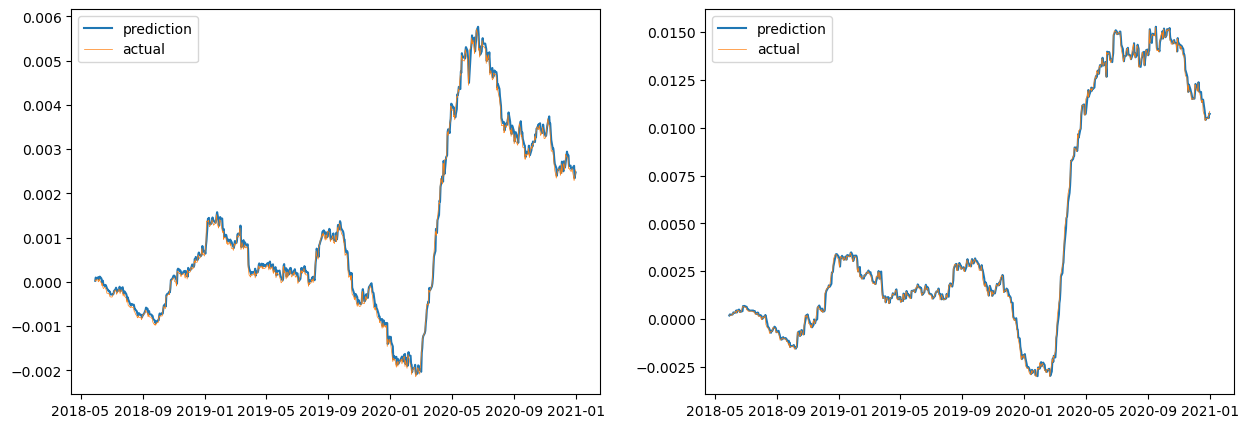

C:\Users\yoshi\AppData\Local\Temp\ipykernel_53084\3727613902.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[var].legend(loc='upper left')


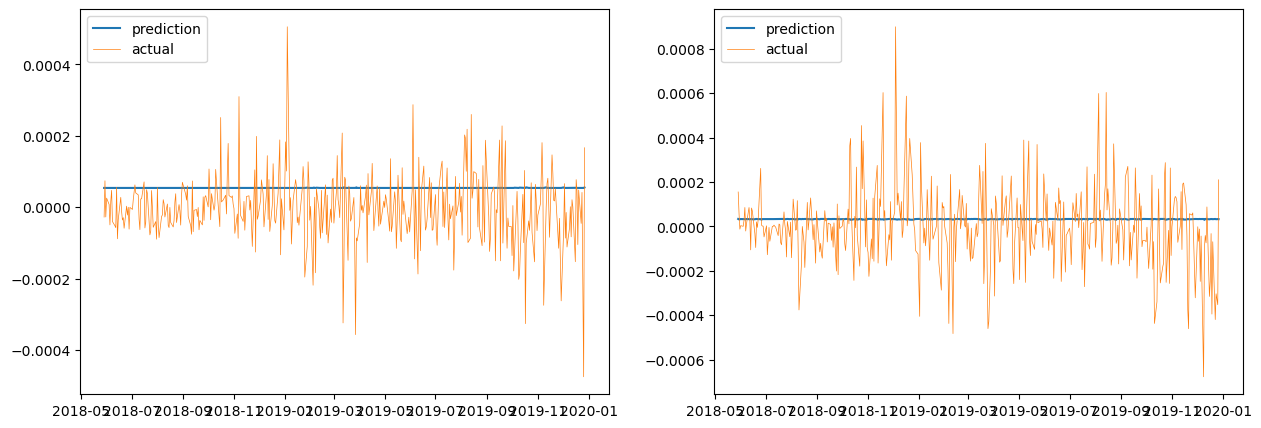

[[1.         0.99915157]
 [0.99915157 1.        ]]
[[ 1.         -0.15323173]
 [-0.15323173  1.        ]]


In [6]:
import matplotlib.pyplot as plt

T = len(ModelRNN.tickers)

mod = 0  #SimpleRNN = 0, LSTM = 1

ticker = 'spy'

fig, axes = plt.subplots(1, 2, figsize=(15, 5*T))
for var in [0,1]:
    k = list(ModelRNN.test_pred[ticker].keys())
    pred = ModelRNN.test_pred[ticker][k[mod]][:,var]
    test = ModelRNN.y_test[ticker][:,var]
    test_full = np.cumsum(test)
    pred_full = test_full[:-1]+pred[:-1]
    test_full = test_full[1:]

    
    axes[var].plot(ModelRNN.test_dates[ticker][k[mod]][1:],pred_full, label = "prediction")
    axes[var].plot(ModelRNN.test_dates[ticker][k[mod]][1:],test_full, label = "actual", linewidth=0.5)
    axes[var].legend(loc='upper left')

# Show the plot
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 5*T))
for var in [0,1]:
    k = list(ModelRNN.test_pred[ticker].keys())
    pred = ModelRNN.test_pred[ticker][k[mod]][:,var]
    test = ModelRNN.y_test[ticker][:,var]
    test_full = np.cumsum(test)
    pred_full = test_full[:-1]+pred[:-1]
    test_full = test_full[1:]

    axes[var].legend(loc='upper left')
    TT = 400
    axes[var].plot(ModelRNN.test_dates[ticker][k[mod]][:TT],pred[:TT], label = "prediction")
    axes[var].plot(ModelRNN.test_dates[ticker][k[mod]][:TT],test[:TT], label = "actual", linewidth=0.5)
    axes[var].legend(loc='upper left')

# Show the plot
plt.show()

print(np.corrcoef(test_full,pred_full))
print(np.corrcoef(test,pred))

In [4]:
ModelRNN.df['spy']


,bp,cp,bn,cn
0,0.004922,1.543797,0.010155,0.663546
1,0.004924,1.552050,0.010386,0.664119
2,0.005047,1.489840,0.010627,0.633336
3,0.005081,1.484949,0.010663,0.642435
4,0.004948,1.557547,0.010528,0.662501
...,...,...,...,...
3268,0.007635,1.561376,0.017765,0.648019
3269,0.007354,1.636439,0.017730,0.655248
3270,0.007436,1.607149,0.017971,0.641017
3271,0.007485,1.595255,0.017955,0.640911


Text(0.5, 0, 'epoch')

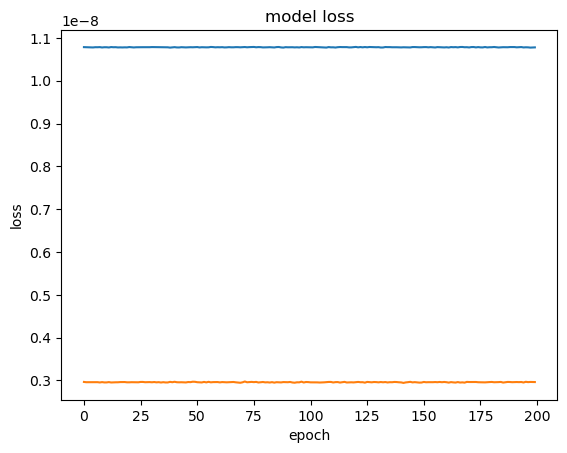

In [5]:
k = list(ModelRNN.test_pred[ticker].keys())
var = 0 #bp = 0, bn = 1

plt.plot(ModelRNN.history['spy'][k[1]][var].history['loss'])
plt.plot(ModelRNN.history['spy'][k[1]][var].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper right')